---
<div align="center">

# Lung Cancer Classification with

CT [Computerized Tomography] Data
-
</div>

---

---
## Index
---

> INSERT PROJECT INDEX HERE

---
## Problem Formulation
---

### Context

Lung cancer remains the leading cause of cancer-related mortality worldwide. Unfortunately, only 16% of cases are diagnosed at an early, localized stage, where patients have a five-year survival rate exceeding 50%. When lung cancer is identified at more advanced stages, the survival rate plummets to just 5%.

Given this stark difference, early diagnosis is critical for improving patient outcomes. Non-invasive imaging methods, such as computed tomography (CT), have proven effective in providing crucial information regarding tumor status. This opens opportunities for developing computer-aided diagnosis (CAD) systems capable of assessing the malignancy risk of lung nodules and supporting clinical decision-making.

### Resolution Approach

Due to factors like high inter-observer variability in visual assessments and the large volumes of radiological data to be analyzed, developing fully automated diagnostic systems is increasingly appealing.

The goal of this project is to create a machine learning-based solution for classifying lung nodules as benign or malignant using CT images. The publicly available LIDC-IDRI dataset, containing expertly annotated CT scans of the human torso, will serve as the primary data source. By employing advanced feature extraction techniques (e.g., radiomics) and modern machine learning algorithms, the aim is to accurately predict the malignancy of detected nodules.

### Planned Work

The project will involve several key steps, including:

- ``Data Preprocessing`` : Cleaning and preparing the CT scan data to ensure its quality and consistency for further analysis.
- ``Feature Engineering`` : Leveraging radiomics and deep learning techniques to extract meaningful features from the scans.
- ``Model Development`` : Training and fine-tuning machine learning models to accurately classify lung nodules based on their malignancy status.
- ``Performance Evaluation`` : Assessing model performance using key metrics such as accuracy and AUC, and validating results through robust methods such as k-fold cross-validation.
  
The ultimate objective of this automated classification system is to aid in clinical decision-making, offering a supplementary screening tool that reduces the workload on radiologists while improving early detection rates for lung cancer.

---
## Project Dependencies
---

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Remove Warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import statistics as stats
import pandas as pd
import matplotlib.pyplot as plt
import os
from pprint import (pprint)

import radiomics
from radiomics import (featureextractor)

import customPylidc as pl
from customPylidc import (ClusterError)

from FeatureExtraction import (extractPyradiomicsFeatures)

from DataPreProcessing.PylidcDataPreProcessing import (createPylidcInitialDataframe, extractPylidcFeatures, processIndeterminateNodules, binarizeTargetLabel)
from DataPreProcessing.PyradiomicsDataPreProcessing import (refactorPyradiomicsDataset, mapTuplesInsideDataframe)
from DataPreProcessing.DataPreProcessing import (performDataNormalization, removeHighlyCorrelatedFeatures)
from DataPreProcessing.DataVisualization import (plotFeatureDistribution)

from sklearn.svm import SVC
from sklearn.ensemble import (RandomForestClassifier, VotingClassifier)
from xgboost import (XGBClassifier)

from ModelDevelopmentAndEvaluation.DataPartitioning import (stratifiedGroupSplit, stratifiedGroupKFoldSplit)
from ModelDevelopmentAndEvaluation.GridSearch import (jsonFileToDict, computeModelBestParameters)
from ModelDevelopmentAndEvaluation.DataVisualization import (evaluateModel)

from Utils.Configuration import (loadConfig, loadModelsParameterGrids, loadModelsPaths)

In [4]:
# Loading the Configs
config = loadConfig()
modelParameterGrids = loadModelsParameterGrids()
modelPaths = loadModelsPaths()

---
## Data Preprocessing
---

This section focuses on the extraction, analysis, and cleaning of the CT scan data from the LIDC-IDRI dataset, making use of the pylidc and pyradiomics libraries.

### LIDC-IDRI Dataset

The LIDC-IDRI is a lung cancer screening dataset which comprises thoracic CT scans for a total of 1010 patients, alongside annotated nodules belonging to one of three classes: 

<table>
  <tr>
    <th colspan="2">Nodules Classification</th>
  </tr>
  <tr>
    <th>Class Label</th>
    <th>Diameter</th>
  </tr>
  <tr>
    <td align="center">Nodule</td>
    <td>$$ \ge \space 3 \space mm$$</td>
  </tr>
  <tr>
    <td align="center">Nodule</td>
    <td>$$ < \space 3 \space mm$$</td>
  </tr>
  <tr>
    <td align="center">Non-Nodule</td>
    <td>$$ \ge \space 3 \space mm$$</td>
  </tr>
</table>

These annotations were performed through a two-phase process by four experienced radiologists. In addition to the CT images, the dataset provides annotations on malignancy, nodule/non-nodule locations, and clinical information about the patients.

This dataset contains a standardized DICOM representation of the annotations and characterizations gathered by the LIDC/IDRI initiative, which were originally stored in XML format. Only nodules with a largest planar dimension of 3 mm or greater have been annotated and characterized by expert radiologists, and only these nodules are included in the current dataset.

The conversion was facilitated by the pylidc library, which handles XML parsing, volumetric reconstruction of the nodule annotations, clustering of annotations for the same nodule, and the calculation of nodule volume, surface area, and largest diameter.

---
### Initial Data Analysis
---

In this initial phase, we will focus on analyzing the data available in the pylidc package to gain deeper insights into how we can utilize this information to later detect nodule malignancy using machine learning algorithms.

After thoroughly reviewing the pylidc package documentation, we discovered that each patient is associated with a Scan, which may include multiple nodule annotations from different doctors who aimed to accurately identify the malignancy stage of the nodules within each CT Scan.

---
#### Population Dimensions
---

We decided to begin by analyzing the characteristics of the population, specifically focusing on the number of patients, scans and annotations.

In [5]:
# Checking the amount of patients available
print(f"There are {np.unique(np.array([scan.patient_id for scan in pl.query(pl.Scan).all()])).size} Total Patients")

There are 1010 Total Patients


In [6]:
# Checking the amount of scans available
print(f"There are {len(pl.query(pl.Scan).all())} Scans available")

There are 1018 Scans available


In [7]:
# Checking the amount of Annotations available
print(f"There are {len(pl.query(pl.Annotation).all())} Annotation available")

There are 6859 Annotation available


In [8]:
# Getting all the patient IDs
patientIds = sorted(np.unique([patient[0] for patient in pl.query(pl.Scan.patient_id).all()]))

# Calculate the amount of scans per patient
numberScansPerPatient = [len(pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).all()) for pid in patientIds]

# Calculate the range value of Scans per all the Patients
uniqueScansPerPatient = np.unique(numberScansPerPatient)
print(f"The dataset contains patients with:")
[print(f"-> {uniqueScans} Scan(s)") for uniqueScans in uniqueScansPerPatient];

The dataset contains patients with:
-> 1 Scan(s)
-> 2 Scan(s)


In [9]:
# Get the patient ids with 1 Scan
idsPatientsOneScan = [idx + 1 for (idx, numberScans) in enumerate(numberScansPerPatient) if numberScans == 1]
print(f"The dataset contains {len(idsPatientsOneScan)} / {len(patientIds)} patinets with 1 Scan")

# Get the patient ids with more than 1 Scan
idsPatientsTwoScans = [idx + 1 for (idx, numberScans) in enumerate(numberScansPerPatient) if numberScans > 1]
print(f"The dataset contains {len(idsPatientsTwoScans)} / {len(patientIds)} patinets with 2 Scans")

The dataset contains 1002 / 1010 patinets with 1 Scan
The dataset contains 8 / 1010 patinets with 2 Scans


---
#### [LIDC-IDRI-0001] Patient Nodule Visualization
---

Then, we wanted to visualize how the first patient nodule's data looked like.

In [10]:
# Choose a patient ID
pid = 'LIDC-IDRI-0001'

# Fetch the patient's scan
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()

# Get the Patient Nodules Annotations
patientNodules = scan.cluster_annotations()
print(f"The Patient {pid}'s Scan has {len(patientNodules)} Nodule(s)")

# Get the Scan's first annotation
ann = scan.annotations[0]

The Patient LIDC-IDRI-0001's Scan has 1 Nodule(s)


In [11]:
# Cluster the Annotations to the Patient Nodules
nods = scan.cluster_annotations()

# Print the Number of Nodules the patient has
print("%s has %d nodule(s)." % (scan.patient_id, len(nods)))

# Print the number of annotations for each one of the patient's nodules
for i, nod in enumerate(nods):
    print("Nodule %d has %d annotation(s)." % (i+1, len(nods[i])))

LIDC-IDRI-0001 has 1 nodule(s).
Nodule 1 has 4 annotation(s).


Loading dicom files ... This may take a moment.


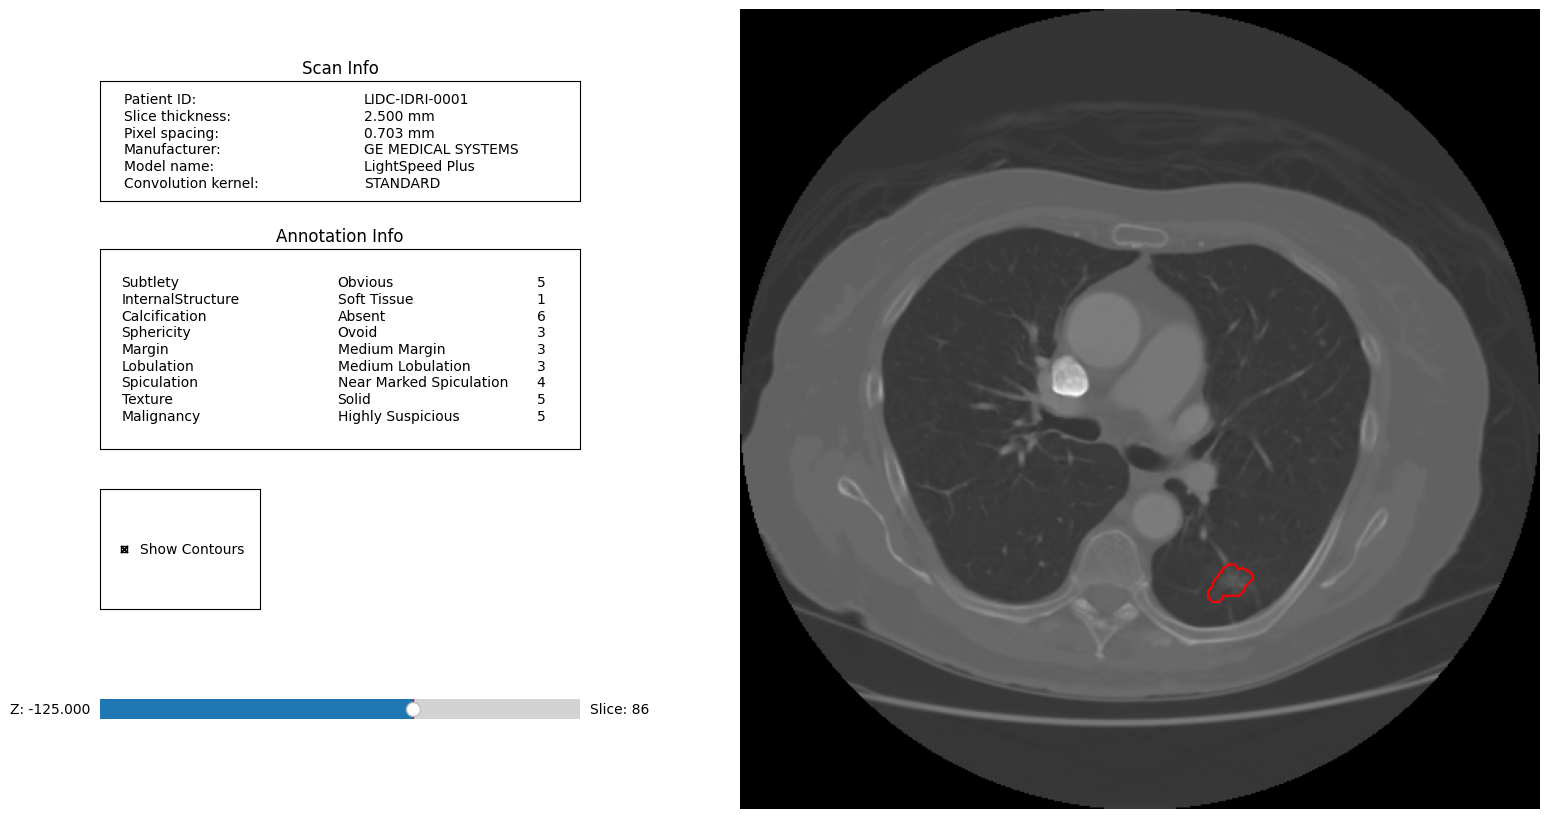

In [12]:
# Visualize the CT Scan
ann.visualize_in_scan()

Loading dicom files ... This may take a moment.


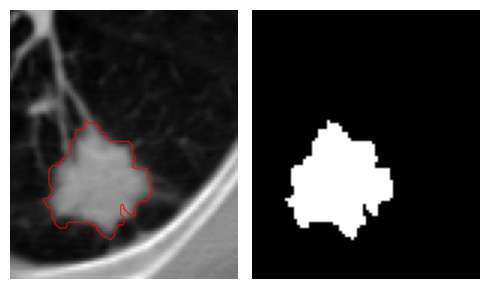

In [13]:
# Plot the Nodule's Mask
ann.visualize_nodule_mask()

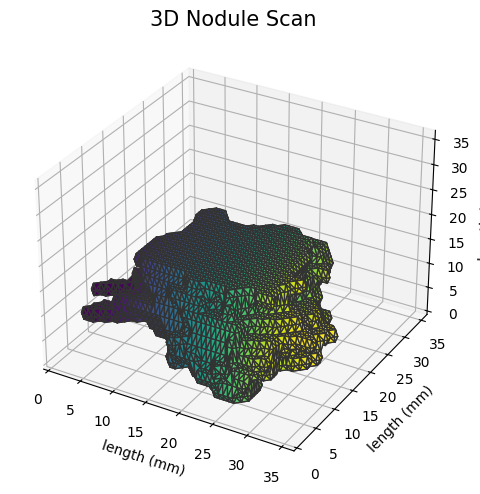

In [14]:
# Plot the Nodule 3D Scan
ann.visualize_in_3d()

---
### [PyLIDC] Features Dataset
---

The pylidc Python package is an essential tool for working with the LIDC-IDRI lung CT scan dataset, providing streamlined access to DICOM files, radiologist-drawn nodule contours, and subjective ratings such as malignancy. It facilitates querying specific nodules based on various attributes and also constructing consensus on the nodule volumes through multiple radiologists’ annotations. 

This package supports a wide range of applications, including medical imaging research, radiomics analysis, and the development or evaluation of machine learning models for lung nodule detection and characterization.

---
#### [PyLIDC] Feature Extraction
---

After reviewing and reconsidering the Nodule Attributes in the [Pylidc package documentation](https://pylidc.github.io/) (as also summarized in the [README.md](./customPylidc/README.md) file within our customPylidc package), we selected those which we believe could contribute most significantly to predicting nodule malignancy. Consequently, we created a simple framework for dataset creation, which will be populated by querying the data from the aforementioned package.

In [15]:
# If the results have yet to be extracted (The .csv file with the pylidc features does not exist)
if not os.path.exists(config['pylidcFeaturesFilename']):
    df_pylidc = extractPylidcFeatures(config['pylidcFeaturesFilename'])
else:
    df_pylidc = pd.read_csv(config['pylidcFeaturesFilename'])

In [16]:
# Get some information regarding the dataset
df_pylidc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2617 entries, 0 to 2616
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   nodule_id          2617 non-null   object 
 1   slice_thickness    2617 non-null   float64
 2   pixel_spacing      2617 non-null   float64
 3   slice_spacing      2617 non-null   float64
 4   subtlety           2617 non-null   int64  
 5   internalStructure  2617 non-null   int64  
 6   calcification      2617 non-null   int64  
 7   sphericity         2617 non-null   int64  
 8   margin             2617 non-null   int64  
 9   lobulation         2617 non-null   int64  
 10  spiculation        2617 non-null   int64  
 11  texture            2617 non-null   int64  
 12  diameter           2617 non-null   float64
 13  surface_area       2617 non-null   float64
 14  volume             2617 non-null   float64
 15  malignancy         2617 non-null   int64  
dtypes: float64(6), int64(9),

In [17]:
# Check the dataframe dimensions
(rows, cols) = df_pylidc.shape
print(f"The pylidc feature dataset contains {rows} rows and {cols} cols")

The pylidc feature dataset contains 2617 rows and 16 cols


In [18]:
# Inspect the new dataset
df_pylidc.head(3)

,nodule_id,slice_thickness,pixel_spacing,slice_spacing,subtlety,internalStructure,calcification,sphericity,margin,lobulation,spiculation,texture,diameter,surface_area,volume,malignancy
0,LIDC-IDRI-0001-1,2.50,0.703125,2.50,5,1,6,3,4,3,5,5,32.755812,2491.466573,6989.673615,5
1,LIDC-IDRI-0002-1,1.25,0.681641,1.25,2,1,6,5,1,1,1,1,30.781671,2807.198994,7244.667508,5
2,LIDC-IDRI-0003-1,2.50,0.820312,2.50,5,1,6,4,3,2,2,4,31.134465,2179.792304,6161.853145,5


---
#### [PyLIDC] Feature Cleaning and Analysis
---

In this subsection, we aim to conduct an exploratory data analysis along with thorough data cleaning on the PyLIDC dataset, which will allow us to effectively prepare this data for the machine learning algorithms we plan to use to address the problem.

We began by analyzing the distribution of the malignancy feature [Target Class] within the dataset population.

---
#### Malignancy Distribution Analysis
---

The data from the pylidc framework represents the medical evaluation of the nodules by doctors. Therefore, we determined it would be more suitable to analyze the distribution of nodular malignancy using the information directly provided in the dataset. This approach provided a clearer insight into how malignancy is classified by medical professionals, which ultimately improved our later data analysis.

In [19]:
# Define a target label decoder
multiClassTargetDecoder = {
    1:'Highly Unlikely',
    2:'Moderately Unlikely',
    3:'Indeterminate',
    4:'Moderately Suspicious',
    5:'Highly Suspicious'
}

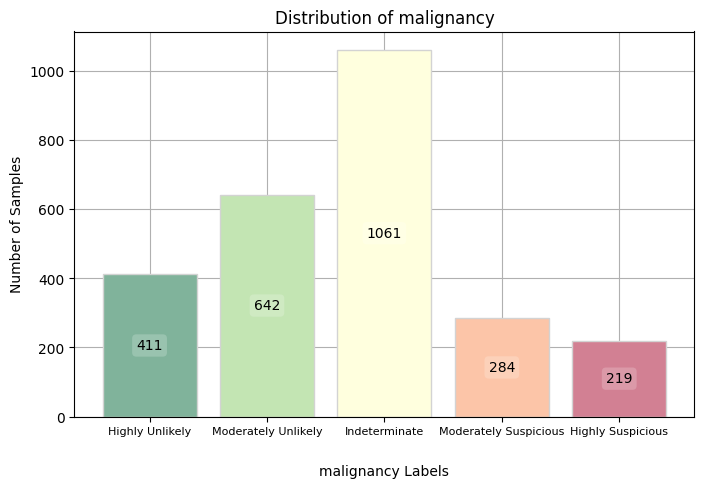

In [20]:
# Plot Malignancy class distribution
plotFeatureDistribution(df_pylidc, 'malignancy', True, multiClassTargetDecoder)

As we can observe from the Distribution of Malignancy on the Population, there are two main approaches:

<td>&nbsp;&nbsp;&rightarrow; Multi-Class Classification 
    <dd>We can utilize all the extracted information to address a multi-class classification problem.</dd> 
</td> 
<td>&nbsp;&nbsp;&rightarrow; Binary Classification [Target Label Binarization] 
    <dd>Given the complexity of the multi-label target feature, we can adapt the data to transform the problem into a binary classification task.</dd>
</td>

#### Multi-Class Classification

Given that the dataset already contains 5 distinct labels to assess the malignancy of lung nodules, we can utilize it as is, without altering the target class structure, which makes multi-class classification a suitable approach.

In [21]:
# Check if the multi-class dataset has already been computed (Is the same as the original pylidc_features.csv)
if not os.path.exists(config['multiClassPylidcFeaturesFilename']):
    # Save the dataset to later perform Multi-Class Classification
    df_pylidc.to_csv(config['multiClassPylidcFeaturesFilename'], sep=',', index=False)

#### Binary Classification [Target Label Binarization]

To reduce the number of labels within the target class, we can either remove or modify the target labels for entries with a malignancy level of 3 (which indicates an indeterminate level of nodular malignancy). Additionally, we can group labels 1 and 2 together, as well as labels 4 and 5, effectively converting the task into a binary classification problem. 

We aim to perform a thoughtful label conversion, as the current labels do not improve the binary classification performance of machine learning models. By reassessing these cases, we hope to enhance the overall classification accuracy.

To address the indeterminate cases, one approach is to use K-Means clustering. We can train the model on the non-indeterminate cases and then predict which clusters the indeterminate nodules belong to, assigning them to a specific class rather than leaving them under a neutral label.

Another option was to use a Naive Bayes classifier to estimate the probability of each indeterminate nodule belonging to one of the existing classes, and update its target label based on the model's prediction. Although we implemented this approach, we ultimately decided not to include it in the project.

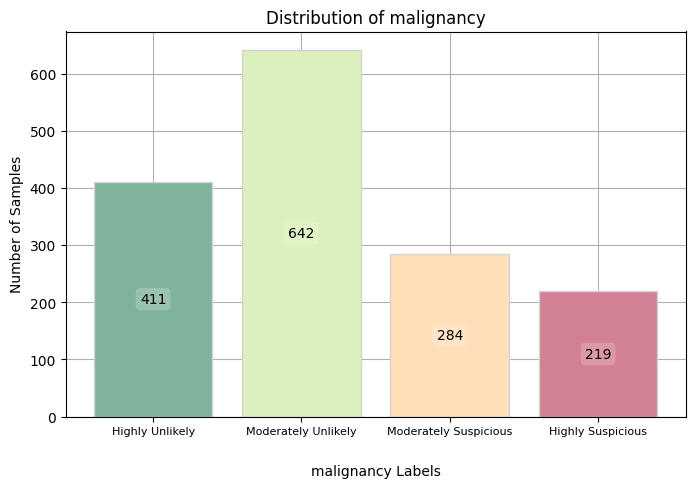

In [22]:
# Remove neutral cases from the dataset
df_remove = processIndeterminateNodules(df_pylidc, "remove")

# Plot the updated target feature distribution
plotFeatureDistribution(df_remove, 'malignancy', True, multiClassTargetDecoder)

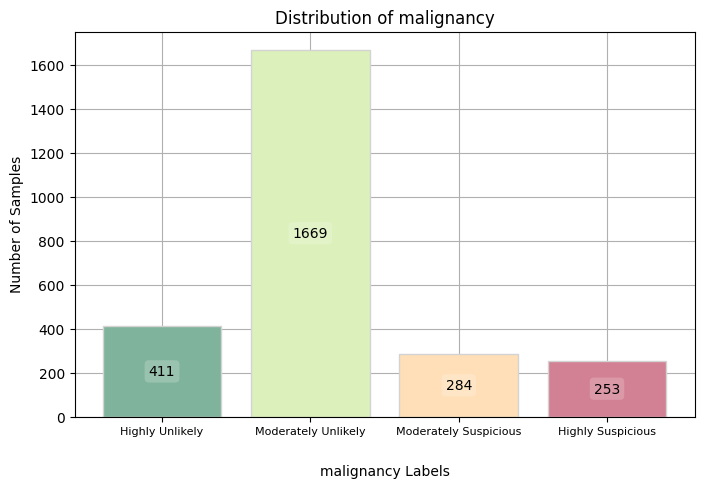

In [23]:
# Process indeterminate Nodules using the K-Means algorithm
df_kmeans = processIndeterminateNodules(df_pylidc, "kmeans")

# Plot the updated target feature distribution
plotFeatureDistribution(df_kmeans, 'malignancy', True, multiClassTargetDecoder)

In [24]:
# Perform Binarization
df_binary_pylidc = binarizeTargetLabel(df_pylidc, "kmeans", config['binaryPylidcFeaturesFilename'])

In [25]:
# Create a target decoder to visualize the binary target labels
binaryTargetDecoder = {
    0:'Highly Unlikely',
    1:'Highly Suspicious'
}

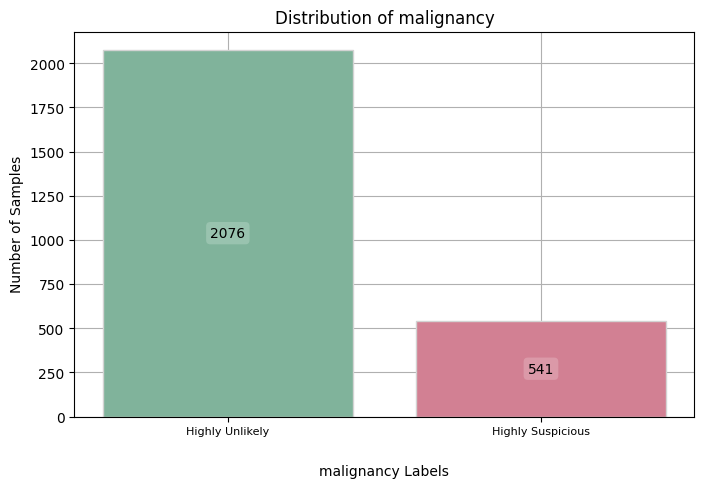

In [26]:
# Plot the updated target feature distribution
plotFeatureDistribution(df_binary_pylidc, 'malignancy', True, binaryTargetDecoder)

---
## Feature Engineering
---

In this project, the primary goal of feature engineering is to enrich the dataset by incorporating quantitative features that enhance the distinction between benign and malignant nodules. These features will play a critical role in developing more accurate models capable of detecting subtle patterns and complex relationships within the imaging data. By doing so, we aim to significantly improve diagnostic precision, leading to better predictive performance and ultimately contributing to more informed clinical decision-making and improved patient outcomes.

---
### [Pyradiomics] Features Dataset
---

The pyradiomics Python package is a versatile tool designed for extracting quantitative radiomic features from medical images, providing a robust framework for imaging analysis in research and clinical contexts. It supports a wide array of feature types, including first-order statistics, shape-based metrics, and texture features derived from advanced matrices like GLCM and GLSZM, and allows for multi-scale analysis through wavelet filters. With support for multiple imaging modalities and file formats, and integration with segmentation tools to target regions of interest (ROIs), pyradiomics offers extensive customizability and the ability to define custom workflows and feature sets, making it suitable for a variety of research applications.

In contrast to pylidc, which focuses on lung CT data and radiologist annotations within the LIDC-IDRI dataset, pyradiomics provides a more comprehensive feature extraction framework that is not limited to specific datasets or anatomical regions. While pylidc is centered on managing and visualizing nodule annotations, pyradiomics facilitates detailed quantitative analysis, making it a valuable tool for radiomics research and the development of predictive models based on medical imaging data.

---
#### [Pyradiomics] Feature Extraction
---

By utilizing the pyradiomics library, our goal is to expand the feature set in our dataset to achieve more accurate results, ultimately leading to a more precise assessment of the malignancy of the patient's nodules.

We began by analyzing the structure of the LIDC-IDRI dataset, which is organized across multiple nested folders, to locate the relevant files. After understanding the directory layout, we adapted a script and configuration file from the pyradiomics GitHub repository. This allowed us to create a new script capable of efficiently extracting the majority of the available data related to the patient's nodules.

For the configurations, we chose to extract 3D features because this approach captures the full volumetric information of the nodules, ensuring a more detailed analysis of their shape and texture. By accounting for the spatial relationships between slices, 3D extraction provides a more comprehensive and reliable representation of the nodule's structure, which is critical for accurately assessing malignancy.

After generating the new dataset with these features, we then cleaned and refactored it, organizing each entry to represent a patient's nodule for further analysis.

In [27]:
# Variable to determine if we perform feature extration using the pyradiomics package
extractPyradiomicsFeatures = False

# Perform Pyradiomics Feature Extraction
if extractPyradiomicsFeatures:
    files_path = 'c:\\Insert\\Global\\Path\\To\\LIDC-IDRI'
    extractPyradiomicsFeatures(Lidc_IdrFilesPath=files_path,
                               pyradiomicsDcmScriptPath='./pyradiomics-dcm.py',
                               pyradiomicsParamsFilePath='./Pyradiomics_Params.yaml',
                               pyradiomicsFeatureDictFilePath='./featuresDict.tsv',
                               startPatient=0,
                               outputDirectoryPath='./OutputSR',
                               tempDirectoryPath='./TempDir')
# Load the dataset
else:
    df_pyradiomics = pd.read_csv(config['pyradiomicsFeaturesFilename'], index_col=False)

In [28]:
# Get some information regarding the dataset
df_pyradiomics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4688 entries, 0 to 4687
Columns: 1599 entries, annotation_id to logarithm_ngtdm_Strength
dtypes: float64(1565), int64(4), object(30)
memory usage: 57.2+ MB


In [29]:
# Check the dataframe dimensions
(rows, cols) = df_pyradiomics.shape
print(f"The pyradiomics feature dataset contains {rows} rows and {cols} cols")

The pyradiomics feature dataset contains 4688 rows and 1599 cols


In [30]:
# Inspect the first rows from the dataset
df_pyradiomics.head(3)

,annotation_id,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,...,logarithm_gldm_LargeDependenceLowGrayLevelEmphasis,logarithm_gldm_LowGrayLevelEmphasis,logarithm_gldm_SmallDependenceEmphasis,logarithm_gldm_SmallDependenceHighGrayLevelEmphasis,logarithm_gldm_SmallDependenceLowGrayLevelEmphasis,logarithm_ngtdm_Busyness,logarithm_ngtdm_Coarseness,logarithm_ngtdm_Complexity,logarithm_ngtdm_Contrast,logarithm_ngtdm_Strength
0,LIDC-IDRI-0001-1,v3.1.0,1.24.3,2.4.0,1.6.0,3.9.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",536a24a547656a8d43436937029df0d651b44259,3D,...,0.315204,0.038768,0.437417,662.328267,0.014300,0.143802,0.002087,36576.623708,6.768040,14.090091
1,LIDC-IDRI-0001-2,v3.1.0,1.24.3,2.4.0,1.6.0,3.9.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",536a24a547656a8d43436937029df0d651b44259,3D,...,0.030970,0.009428,0.439498,682.658274,0.006310,0.099596,0.002513,31985.177011,5.824263,14.843045
2,LIDC-IDRI-0001-3,v3.1.0,1.24.3,2.4.0,1.6.0,3.9.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",536a24a547656a8d43436937029df0d651b44259,3D,...,0.051793,0.013446,0.478543,777.359773,0.007703,0.117973,0.002163,39403.439571,6.843639,14.682214


In [31]:
# Split the 'annotation_id' column into 'patient_id' and 'nodule_id'
df_pyradiomics[['patient_id', 'ann_id']] = df_pyradiomics['annotation_id'].str.rsplit('-', n=1, expand=True)

# Reorder the columns to move 'patient_id' and 'nodule_id' to the beginning
cols = ['patient_id', 'ann_id'] + [col for col in df_pyradiomics.columns if col not in ['patient_id', 'ann_id']]

# Drop 'annotation_id' and reorder the DataFrame
df_pyradiomics = df_pyradiomics[cols]

# Remove the annotation id column
df_pyradiomics = df_pyradiomics.drop(columns=['annotation_id'], axis=1)

In [32]:
df_pyradiomics.iloc[:, 143:] = df_pyradiomics.iloc[:, 143:].apply(lambda x: x.shift(273) if x.isna().any() else x, axis=1)

# Drop rows with NaN Values
df_pyradiomics = df_pyradiomics.dropna(how='any')

df_pyradiomics.head(3)

,patient_id,ann_id,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,...,logarithm_gldm_LargeDependenceLowGrayLevelEmphasis,logarithm_gldm_LowGrayLevelEmphasis,logarithm_gldm_SmallDependenceEmphasis,logarithm_gldm_SmallDependenceHighGrayLevelEmphasis,logarithm_gldm_SmallDependenceLowGrayLevelEmphasis,logarithm_ngtdm_Busyness,logarithm_ngtdm_Coarseness,logarithm_ngtdm_Complexity,logarithm_ngtdm_Contrast,logarithm_ngtdm_Strength
0,LIDC-IDRI-0001,1,v3.1.0,1.24.3,2.4.0,1.6.0,3.9.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",536a24a547656a8d43436937029df0d651b44259,...,0.315204,0.038768,0.437417,662.328267,0.014300,0.143802,0.002087,36576.623708,6.768040,14.090091
1,LIDC-IDRI-0001,2,v3.1.0,1.24.3,2.4.0,1.6.0,3.9.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",536a24a547656a8d43436937029df0d651b44259,...,0.030970,0.009428,0.439498,682.658274,0.006310,0.099596,0.002513,31985.177011,5.824263,14.843045
2,LIDC-IDRI-0001,3,v3.1.0,1.24.3,2.4.0,1.6.0,3.9.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",536a24a547656a8d43436937029df0d651b44259,...,0.051793,0.013446,0.478543,777.359773,0.007703,0.117973,0.002163,39403.439571,6.843639,14.682214


In [33]:
# Check if is has already been created
if not os.path.exists(config['pyradiomicsRefactoredFeaturesFilename']):
    df_refactored_pyradiomics = refactorPyradiomicsDataset(df_pyradiomics, config['pyradiomicsRefactoredFeaturesFilename'], verbose=False)

# Load the refactored dataset
else:
     df_refactored_pyradiomics = pd.read_csv(config['pyradiomicsRefactoredFeaturesFilename'], index_col=False)

In [34]:
# Inspect the new refactored dataframe
df_refactored_pyradiomics.head(3)

,nodule_id,patient_id,ann_id,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,...,logarithm_gldm_LargeDependenceLowGrayLevelEmphasis,logarithm_gldm_LowGrayLevelEmphasis,logarithm_gldm_SmallDependenceEmphasis,logarithm_gldm_SmallDependenceHighGrayLevelEmphasis,logarithm_gldm_SmallDependenceLowGrayLevelEmphasis,logarithm_ngtdm_Busyness,logarithm_ngtdm_Coarseness,logarithm_ngtdm_Complexity,logarithm_ngtdm_Contrast,logarithm_ngtdm_Strength
0,LIDC-IDRI-0001-1,LIDC-IDRI-0001,1,v3.1.0,1.24.3,2.4.0,1.6.0,3.9.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",...,0.125483,0.020089,0.454728,708.128969,0.009230,0.123915,0.002229,35948.350251,6.665276,14.423402
1,LIDC-IDRI-0002-1,LIDC-IDRI-0002,1,v3.1.0,1.24.3,2.4.0,1.6.0,3.9.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",...,104.713631,0.517346,0.083483,76.432466,0.012528,1.814987,0.007012,1896.840261,0.618637,52.197389
2,LIDC-IDRI-0003-1,LIDC-IDRI-0003,1,v3.1.0,1.24.3,2.4.0,1.6.0,3.9.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",...,209.395329,0.693513,0.032239,1.005262,0.008692,13.673589,0.009964,15.072607,0.017851,4.623489


---
#### [Pyradiomics] Feature Cleaning and Processing
---

By cleaning the pyradiomics dataset, we aim to improve the quality and consistency of the data. The removal of noise, correcting errors, and eliminating irrelevant features, helps us ensure that each entry accurately represents a patient's nodule which simplifies the data for analysis, leading to more reliable machine learning models.

We began by examining the different data types within the dataset and reviewing sample values from each feature. This allowed us to better understand the significance of each feature, how they are formatted, and how we could further enhance their representation within the dataset.

In [35]:
# Get the dtypes from the features
colsTypes = np.unique(list(df_refactored_pyradiomics.dtypes))
print(f"The pyradiomics dataset is composed of features with the following dtypes: \n")
[print(f"-> {col}") for col in colsTypes]
print()

The pyradiomics dataset is composed of features with the following dtypes: 

-> int64
-> float64
-> object



Most of the data types are already correctly formatted as int64 and float64. However, we need to closely inspect the object type features, as they may either contain valuable information or add noise to the dataset. Therefore, these features should be carefully selected and processed based on their content and structure.

In [36]:
# Get a dataframe with all the object type features
df_object_features = df_refactored_pyradiomics.select_dtypes(include=['object'])

In [37]:
# Check the data inside each object feature
for column in df_object_features.columns:
    print(f"[{column}] -> {df_object_features[column][0]}\n")

[nodule_id] -> LIDC-IDRI-0001-1

[patient_id] -> LIDC-IDRI-0001

[diagnostics_Versions_PyRadiomics] -> v3.1.0

[diagnostics_Versions_Numpy] -> 1.24.3

[diagnostics_Versions_SimpleITK] -> 2.4.0

[diagnostics_Versions_PyWavelet] -> 1.6.0

[diagnostics_Versions_Python] -> 3.9.0

[diagnostics_Configuration_Settings] -> {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': [2, 2, 2], 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 10, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'binWidth': 25, 'voxelArrayShift': 1000, 'geometryTolerance': 1e-06, 'correctMask': False}

[diagnostics_Configuration_EnabledImageTypes] -> {'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3.0]}, 'Wavelet': {}, 'Gradient': {}, 'Square': {}, 'SquareRoot': {}, 'Exponential': {}, 'Logarithm': {}}

[diagnostics_Image-original_Hash] -> 536a24a547656

<br/>
As we can observe, there are several irrelevant features (such as 'patient_id', and version or hash-related features) that should be removed.
<br/>
<br/>
Additionally, there are features containing 3D information (such as 'diagnostics_Image-interpolated_Size') that should be split into separate columns. This will simplify the model’s learning process during training, making it easier to interpret and utilize the data.
<br/>
<br/>

In [38]:
# Fetching useless features from the pyradiomics dataset to later removed them
columnsToRemove = ['patient_id', 'ann_id', 'diagnostics_Image-original_Dimensionality'] + \
                  [column for column in df_object_features.columns if 'Hash' in column or 'Versions' in column or df_object_features[column][0][0] == '{'] + \
                  [column for column in df_refactored_pyradiomics.columns if 'Num' in column]

In [39]:
try:
    # Drop the columns selected
    df_refactored_pyradiomics = df_refactored_pyradiomics.drop(columns=columnsToRemove, axis=1)
except:
    print("The selected columns have already been removed!")

# Update the Dataframe of the object features
df_object_features = df_refactored_pyradiomics.select_dtypes(include=['object'])

In [40]:
# Fetch the features whoose string data is composed by tuples
tupleColumns = [column for column in df_object_features.columns if df_object_features[column][0][0] == '(']

In [41]:
# Parse strings with tuple format inside the pyradiomics dataset
try:
    df_refactored_pyradiomics = mapTuplesInsideDataframe(df_refactored_pyradiomics, tupleColumns, verbose=False)
except:
    print(f"The String like Tuple features have already been processed.\n")

df_refactored_pyradiomics.head(3)

,nodule_id,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Image-interpolated_Mean,diagnostics_Image-interpolated_Minimum,diagnostics_Image-interpolated_Maximum,diagnostics_Mask-interpolated_Mean,diagnostics_Mask-interpolated_Minimum,diagnostics_Mask-interpolated_Maximum,...,diagnostics_Mask-interpolated_BoundingBox_3,diagnostics_Mask-interpolated_BoundingBox_4,diagnostics_Mask-interpolated_BoundingBox_5,diagnostics_Mask-interpolated_BoundingBox_6,diagnostics_Mask-interpolated_CenterOfMassIndex_1,diagnostics_Mask-interpolated_CenterOfMassIndex_2,diagnostics_Mask-interpolated_CenterOfMassIndex_3,diagnostics_Mask-interpolated_CenterOfMass_1,diagnostics_Mask-interpolated_CenterOfMass_2,diagnostics_Mask-interpolated_CenterOfMass_3
0,LIDC-IDRI-0001-1,-826.943929,-2048.0,3071.0,-412.472265,-988.332443,1016.145157,-78.624550,-830.888565,233.304367,...,0.0,13.0,16.0,10.0,16.612761,19.668867,4.528053,55.873960,86.286171,-116.193894
1,LIDC-IDRI-0002-1,-826.943929,-2048.0,3071.0,-564.912672,-1013.177460,1022.079742,-797.314835,-983.115417,154.665916,...,0.0,15.0,10.0,17.0,17.457944,16.253672,8.120160,60.075067,72.666523,-104.134680
2,LIDC-IDRI-0003-1,-826.943929,-2048.0,3071.0,-563.521360,-982.593091,946.504822,-856.918832,-962.924475,-349.836878,...,0.0,13.0,14.0,10.0,18.128906,16.902344,5.667969,74.047656,74.394531,-212.914062


---
### Final Features Dataset
---

After building the previous datasets, the next step is to merge them based on the 'nodule_id' feature to create a more comprehensive and robust dataset. This combined dataset will be used to train our models, ultimately helping doctors make more accurate clinical assessments of the malignancy of the patient's nodules.

In [42]:
# Merge both datasets and clean them
df_final = pd.merge(df_binary_pylidc, df_refactored_pyradiomics, on='nodule_id')
df_final.head(3)

,nodule_id,slice_thickness,pixel_spacing,slice_spacing,subtlety,internalStructure,calcification,sphericity,margin,lobulation,...,diagnostics_Mask-interpolated_BoundingBox_3,diagnostics_Mask-interpolated_BoundingBox_4,diagnostics_Mask-interpolated_BoundingBox_5,diagnostics_Mask-interpolated_BoundingBox_6,diagnostics_Mask-interpolated_CenterOfMassIndex_1,diagnostics_Mask-interpolated_CenterOfMassIndex_2,diagnostics_Mask-interpolated_CenterOfMassIndex_3,diagnostics_Mask-interpolated_CenterOfMass_1,diagnostics_Mask-interpolated_CenterOfMass_2,diagnostics_Mask-interpolated_CenterOfMass_3
0,LIDC-IDRI-0001-1,2.50,0.703125,2.50,5,1,6,3,4,3,...,0.0,13.0,16.0,10.0,16.612761,19.668867,4.528053,55.873960,86.286171,-116.193894
1,LIDC-IDRI-0002-1,1.25,0.681641,1.25,2,1,6,5,1,1,...,0.0,15.0,10.0,17.0,17.457944,16.253672,8.120160,60.075067,72.666523,-104.134680
2,LIDC-IDRI-0003-1,2.50,0.820312,2.50,5,1,6,4,3,2,...,0.0,13.0,14.0,10.0,18.128906,16.902344,5.667969,74.047656,74.394531,-212.914062


In [43]:
# Remove rows with at least one null / NaN Value
df_final = df_final.dropna(how='any')

In [44]:
# Inspect the shape of the new dataset
(mergedRows, mergedCols) = df_final.shape
print(f"The merged dataset contains {mergedRows} rows and {mergedCols} columns")

The merged dataset contains 1648 rows and 1634 columns



# [FIX TEXT]
#### &rarr; Data Normalization

We must perform data normalization of the dataset in order for the model to not perfer some features over others, since all of them must have the same weight in the model development.

> The min-max approach (often called normalization) rescales the feature to a hard and fast range of [0,1] by subtracting the minimum value of the feature then dividing by the range. We can apply the min-max scaling in Pandas using the .min() and .max() methods.

In [45]:
# Perform Min-Max Scaling for data normalization
df_final = performDataNormalization(df_final, method='min-max')
df_final.head(3)

,nodule_id,slice_thickness,pixel_spacing,slice_spacing,subtlety,internalStructure,calcification,sphericity,margin,lobulation,...,diagnostics_Mask-interpolated_BoundingBox_3,diagnostics_Mask-interpolated_BoundingBox_4,diagnostics_Mask-interpolated_BoundingBox_5,diagnostics_Mask-interpolated_BoundingBox_6,diagnostics_Mask-interpolated_CenterOfMassIndex_1,diagnostics_Mask-interpolated_CenterOfMassIndex_2,diagnostics_Mask-interpolated_CenterOfMassIndex_3,diagnostics_Mask-interpolated_CenterOfMass_1,diagnostics_Mask-interpolated_CenterOfMass_2,diagnostics_Mask-interpolated_CenterOfMass_3
0,LIDC-IDRI-0001-1,0.431818,0.469697,0.444444,5,1,6,3,4,3,...,0.0,0.6,0.714286,0.363636,0.736490,0.746699,0.266863,0.671376,0.872239,0.713049
1,LIDC-IDRI-0002-1,0.147727,0.428031,0.166667,2,1,6,5,1,1,...,0.0,0.7,0.428571,0.681818,0.784472,0.468571,0.508173,0.684370,0.825063,0.752704
2,LIDC-IDRI-0003-1,0.431818,0.696969,0.444444,5,1,6,4,3,2,...,0.0,0.6,0.619048,0.363636,0.822564,0.521398,0.343440,0.727584,0.831048,0.395000


#### &rarr; Remove Highly Correlated Features

In [46]:
# Remove Highly correlated features
df_final = removeHighlyCorrelatedFeatures(df_final)
df_final.head(3)

,nodule_id,slice_thickness,pixel_spacing,subtlety,internalStructure,calcification,sphericity,margin,lobulation,spiculation,...,diagnostics_Image-interpolated_Spacing_1,diagnostics_Image-interpolated_Spacing_2,diagnostics_Image-interpolated_Spacing_3,diagnostics_Image-interpolated_Size_3,diagnostics_Mask-interpolated_Spacing_1,diagnostics_Mask-interpolated_Spacing_2,diagnostics_Mask-interpolated_Spacing_3,diagnostics_Mask-interpolated_BoundingBox_1,diagnostics_Mask-interpolated_BoundingBox_2,diagnostics_Mask-interpolated_BoundingBox_3
0,LIDC-IDRI-0001-1,0.431818,0.469697,5,1,6,3,4,3,5,...,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.888889,0.666667,0.0
1,LIDC-IDRI-0002-1,0.147727,0.428031,2,1,6,5,1,1,1,...,0.0,0.0,0.0,0.7,0.0,0.0,0.0,0.888889,0.333333,0.0
2,LIDC-IDRI-0003-1,0.431818,0.696969,5,1,6,4,3,2,2,...,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.888889,0.333333,0.0


In [47]:
# Inspect the shape of the final dataset
(finalRows, finalCols) = df_final.shape
print(f"The final dataset contains {finalRows} rows and {finalCols} columns")

The final dataset contains 1648 rows and 552 columns


In [48]:
# Save the Final Dataset
if not os.path.exists(config['finalFeaturesDatasetFilename']):
    df_final.to_csv(config['finalFeaturesDatasetFilename'], sep=',', index=False)

---
## Model Development
---

> SELECT THE ML ALGORITHMS AND WHY
> AUTOMATE A SIMPLE PIPELINE TO TRAIN-TEST THE MODELS BY SPLITTING THE DATA
> PERFORM GRID SEARCH FOR A AUTOMATED HYPER-PARAMETER TUNNING


---
### Data Partitioning
---

> ADD A SIMPLE DESCRIPTION OF HOW THE DATA IS GOING TO BE SPLIT

## Class Imbalance Assessment -> Perform Under/Over Sampling 
Since all machine learning models are not prepared to handle imbalanced datasets, we must adapt the data in order to meet this requirement.

In [49]:
# Split the data using SMOTE in a singular fold to perform a Grid Search
(X_train, X_test, y_train, y_test) = stratifiedGroupSplit(df_final, useSMOTE=True, test_size=0.3)

In [50]:
# Split the data across multiple folds while maintaining a class proportion between train and test sets
# as well as keeping each group in one of these sets (Keeping the nodules of each patient inside the same set)
folds = stratifiedGroupKFoldSplit(df_final, useSMOTE=True, n_splits=5)

---
### Machine Learning Algorithms - Selection
---

> ADD TEXT HERE ABOUT THE MACHINE LEARNING ALGORITHMS SELECTED [MENTION THE HYPER PARAMETER TUNING]

---
#### SVM
---

In [ ]:
# Check if the best parameters have yet to be computed 
if not os.path.exists(modelPaths['SVC']['bestParamsPath']):
    # Compute the best parameters
    svmBestParams = computeModelBestParameters(SVC, modelParameterGrids, X_train, y_train, modelPaths, True)
else:
    # Load already computed parameters
    svmBestParams = jsonFileToDict(modelPaths['SVC']['bestParamsPath'])

In [ ]:
# Define a Model with the best parameters found
svmClassifier = SVC(**svmBestParams)

---
#### Random Forest
---

In [ ]:
# Check if the best parameters have yet to be computed 
if not os.path.exists(modelPaths['RandomForestClassifier']['bestParamsPath']):
    # Compute the best parameters
    randomForestBestParams = computeModelBestParameters(RandomForestClassifier, modelParameterGrids, X_train, y_train, modelPaths, True)
else:
    # Load already computed parameters
    randomForestBestParams = jsonFileToDict(modelPaths['RandomForestClassifier']['bestParamsPath'])

In [ ]:
# Define a Model with the best parameters found
randomForestClassifier = RandomForestClassifier(**randomForestBestParams)

---
#### XGBoost
---

In [51]:
# Check if the best parameters have yet to be computed 
if not os.path.exists(modelPaths['XGBClassifier']['bestParamsPath']):
    # Compute the best parameters
    xgbBestParams = computeModelBestParameters(XGBClassifier, modelParameterGrids, X_train, y_train, modelPaths, True)
else:
    # Load already computed parameters
    xgbBestParams = jsonFileToDict(modelPaths['XGBClassifier']['bestParamsPath'])

In [52]:
# Define a Model with the best parameters found
xgbClassifier = XGBClassifier(**xgbBestParams)

## IMPORTANT: WE ARE TRAINING OVER THE SAME MODEL OVER AND OVER AGAIN -> NEEDS TO BE CHANGED [INSIDE THE evaluateModel function]

## WE CAN ALSO ADD OTHER METRICS (BALANCED ACCURACY, F1-SCORE)

## NOTE: UPDATE ALL THE DATASETS AS WELL -> THOSE WHICH WERE PREPROCESSED INSIDE THIS NOTEBOOK

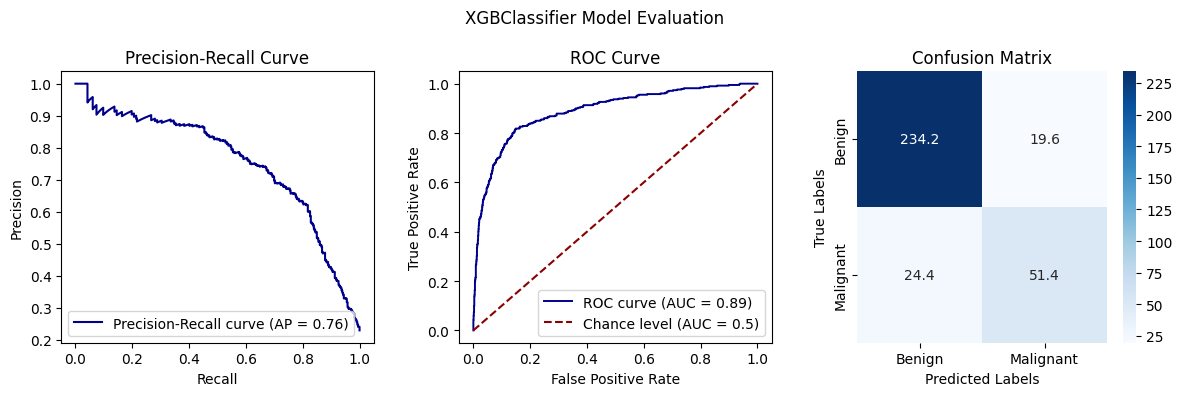

In [53]:
# Calculate and Plot some metrics associated with the XGBoost 
xgbMetrics = evaluateModel(xgbClassifier, folds, modelPaths, ['Benign','Malignant'])

---
## Performance Evaluation
---

> SELECT METRICS USED
> PLOT CONFUSION MATRICES, LEARNING CURVES, ...
> PERFORM A STATISTICAL EVALUATION OF THE MODEL'S RESULTS TO PROPERLY COMPARE THE PERFORMACE OF EACH ML ALGORITHM

<div align="center">

***
## Bibliographic References
***
</div>

1. AUTHOR (DATE OF PUBLICATION). __*ARTICLE TITLE*__. Available [here](__INSERT_LINK__)

___
## Video Presentation (YouTube Video)

Moreover, you can find the **Video** for our **Project's Presentation [here](https://youtu.be/dQw4w9WgXcQ?si=CjDTJSvi37Fyu1kU)**
___
## Final Considerations

$\quad$ If there is any difficulty on downloading or executing this project, please contact us via:

- **Email**:
    - [Francisco Macieira](https://github.com/franciscovmacieira) &#8594; `up202207166@edu.fc.up.pt`
    - [Gonçalo Esteves](https://github.com/EstevesX10) &#8594; `up202203947@edu.fc.up.pt`
    - [Nuno Gomes](https://github.com/NightF0x26) &#8594; `up202206195@edu.fc.up.pt`

---
---
---
---

## TODO:
- Identify and Describe the Problem
- Identify the business, its goals and possible constraints for the solution and the used pipeline
- Weight the 2D vs 3D image processing paradigm and choose which one to use and why

<br/>

- Perform Exploratory Data Analysis [Class Imbalance, Check type of problem - if we can switch from multi-class to binary classification, maybe perform synthetic sampling or data prunning, If there is a lot of data maybe consider a PCA to reduce processing costs]
- Select Algorithms and the reasons behind the choice
- Split the data based on a K-Fold Cross Validation Stratigy
- Perform Grid Search for parameter tunning on each one of the algorithms
- Train the model with the best hyperparameters found and evaluate the performance based on multiple metrics [balanced accuracy, f1-score, ...]
- Perform a statistical evaluation on the model's performance
- Does it achieve the business goals and at what costs?
- Ethical Considerations and identify possible privacy breaches (even though the data is anonimized)
- YouTube Presentation Video
- Bibliographic References